## E-commerce Data Pipeline (AmazonProject-ML3.1)

The file **`amazonproject_ml3_1.py`** performs a complete data cleaning, merging, and preparation workflow for Amazon sales data, preparing it for machine learning.

---

### Main Steps:

1. **Data Loading**
   Loads multiple datasets from local and international sources (Amazon, International, May, and Sale Report).

2. **Initial Cleaning**
   Splits SKU identifiers, standardizes date formats, creates day/month/year columns, and removes invalid entries.

3. **Data Merging**
   Combines all datasets using `SKU_ID_SIZE` as the common key, producing a unified file – `best_dataset.csv`.

4. **Advanced Cleaning**
   Normalizes city names (using RapidFuzz), colors, sizes, and categories; handles missing values; merges duplicate categories.

5. **Feature Engineering**
   Creates new variables such as seasons, weekdays, and flags like `has_promotion`, `b2b`, `amazon_channel`, and `unit_price`.

6. **Final Cleaning**
   Removes columns with over 60% missing data and saves the final clean dataset as
   **`best_dataset_clean_2.1.pkl`**

---

### Summary:

The script produces a clean, unified, and standardized dataset from multiple raw sources, ready for analysis and machine learning within the **AmazonProject-ML** pipeline.


In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

# DATA PREPARATION




### 1. Uploading the data

In [ ]:
Amazon_Report  = pd.read_csv(r"Amazon Sale Report.csv")
Amazon_Report.info()
Amazon_Report.head()

/tmp/ipython-input-635453339.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  Amazon_Report  = pd.read_csv(r"Amazon Sale Report.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [ ]:
# Display unique SKU values
Amazon_Report.SKU.unique()

# Extract the first part before the first hyphen ('-')
Amazon_Report["SKU_ID"] = Amazon_Report["SKU"].str.split("-", n=1).str[0]

# Extract the last part after the last hyphen ('-')
Amazon_Report["SKU_SIZE"] = Amazon_Report["SKU"].str.rsplit("-", n=1).str[-1]

# Create a combined column of SKU_ID and SKU_SIZE
Amazon_Report["SKU_ID_SIZE"] = Amazon_Report["SKU_ID"] + "-" + Amazon_Report["SKU_SIZE"]

# Print the updated DataFrame to verify changes
print(Amazon_Report)

# Display detailed information about the DataFrame (columns, data types, memory usage, etc.)
Amazon_Report.info()


         index             Order ID      Date                        Status  \
0            0  405-8078784-5731545  04-30-22                     Cancelled   
1            1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2            2  404-0687676-7273146  04-30-22                       Shipped   
3            3  403-9615377-8133951  04-30-22                     Cancelled   
4            4  407-1069790-7240320  04-30-22                       Shipped   
...        ...                  ...       ...                           ...   
128970  128970  406-6001380-7673107  05-31-22                       Shipped   
128971  128971  402-9551604-7544318  05-31-22                       Shipped   
128972  128972  407-9547469-3152358  05-31-22                       Shipped   
128973  128973  402-6184140-0545956  05-31-22                       Shipped   
128974  128974  408-7436540-8728312  05-31-22                       Shipped   

       Fulfilment Sales Channel  ship-service-level

In [ ]:
# Display unique values in 'ship-country' column (e.g., 'IN', NaN)
Amazon_Report['ship-country'].unique()  # array(['IN', nan], dtype=object)

# Display unique dates in the 'Date' column (range: 30.3.22 to 29.6.22)
Amazon_Report['Date'].unique()

# Display value counts for 'SKU' (total 7,195 unique values, ranging from 773 to 1)
Amazon_Report['SKU'].value_counts()

# Convert 'SKU' column to string type for text processing
s = Amazon_Report["SKU"].astype("string")

# Condition: keep only values that contain at least one letter and one digit (case-insensitive)
mask = s.str.contains(r"(?i)(?=.*[A-Za-z])(?=.*\d)", na=False)

# Create 'SKU_clean' column: keep valid values only, convert them to uppercase
Amazon_Report["SKU_clean"] = s.where(mask).str.upper()

# Quick validation check (optional)
print(Amazon_Report["SKU_clean"].value_counts(dropna=False).head(20))
print("Kept:", mask.sum(), "| Dropped:", (~mask).sum())

# Display DataFrame information (column names, types, non-null counts, etc.)
Amazon_Report.info()


SKU_clean
JNE3797-KR-L       773
JNE3797-KR-M       657
JNE3797-KR-S       587
JNE3405-KR-L       535
J0230-SKD-M        507
JNE3797-KR-XL      474
J0230-SKD-S        452
JNE3405-KR-S       443
JNE3797-KR-XS      431
JNE3797-KR-XXL     395
JNE3405-KR-M       394
SET268-KR-NP-S     387
JNE3797-KR-XXXL    386
SET268-KR-NP-XL    386
SET268-KR-NP-L     362
SET183-KR-DH-M     343
J0003-SET-S        334
JNE3567-KR-M       317
SET324-KR-NP-M     305
J0230-SKD-L        297
Name: count, dtype: Int64
Kept: 128975 | Dropped: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channe

In [ ]:
# Assume your DataFrame is named Amazon_Report
# Convert the 'Date' column to datetime format
Amazon_Report["DATE_parsed"] = pd.to_datetime(
    Amazon_Report["Date"].astype("string").str.strip(),
    format="%m-%d-%y",
    errors="coerce"  # invalid formats will become NaT
)

# Create new date-related columns
Amazon_Report["day"]     = Amazon_Report["DATE_parsed"].dt.day
Amazon_Report["month"]   = Amazon_Report["DATE_parsed"].dt.month
Amazon_Report["year"]    = Amazon_Report["DATE_parsed"].dt.year
Amazon_Report["weekday"] = Amazon_Report["DATE_parsed"].dt.weekday   # 0 = Monday, 6 = Sunday
Amazon_Report["weekend"] = Amazon_Report["DATE_parsed"].dt.weekday >= 5  # True for Saturday/Sunday

# Convert data types safely (handles NaT values)
Amazon_Report["day"]     = Amazon_Report["day"].astype("Int64")
Amazon_Report["month"]   = Amazon_Report["month"].astype("Int64")
Amazon_Report["year"]    = Amazon_Report["year"].astype("Int64")
Amazon_Report["weekday"] = Amazon_Report["weekday"].astype("Int64")
Amazon_Report["weekend"] = Amazon_Report["weekend"].astype("boolean")

# Preview the first rows to verify changes
print(Amazon_Report.head())


   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel  ship-service-level    Style              SKU  \
0   Merchant      Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant      Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ...   SKU_ID SKU_SIZE   SKU_ID_SIZE        SKU_clean  \
0            Set  ...   SET389

In [ ]:
Amazon_Report.rename(columns={'Qty': 'pcs'}, inplace=True)

In [ ]:
Amazon_Report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               128975 non-null  int64         
 1   Order ID            128975 non-null  object        
 2   Date                128975 non-null  object        
 3   Status              128975 non-null  object        
 4   Fulfilment          128975 non-null  object        
 5   Sales Channel       128975 non-null  object        
 6   ship-service-level  128975 non-null  object        
 7   Style               128975 non-null  object        
 8   SKU                 128975 non-null  object        
 9   Category            128975 non-null  object        
 10  Size                128975 non-null  object        
 11  ASIN                128975 non-null  object        
 12  Courier Status      122103 non-null  object        
 13  pcs                 128975 no

In [ ]:
Cloud  = pd.read_csv(r"Cloud Warehouse Compersion Chart.csv")
Cloud.info()
Cloud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       50 non-null     int64 
 1   Shiprocket  21 non-null     object
 2   Unnamed: 1  41 non-null     object
 3   INCREFF     28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


,index,Shiprocket,Unnamed: 1,INCREFF
0,0,Heads,Price (Per Unit),Price (Per Unit)
1,1,Inbound (Fresh Stock and RTO),₹4.00,4
2,2,Outbound,₹7.00,11
3,3,Storage Fee/Cft,₹25.00,Rs 0.15/- Per Day
4,4,Customer Return with Detailed QC,₹6.00,15.5


In [ ]:
Expense  = pd.read_csv(r"Expense IIGF.csv")
Expense.info()
Expense.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           17 non-null     int64 
 1   Recived Amount  6 non-null      object
 2   Unnamed: 1      6 non-null      object
 3   Expance         15 non-null     object
 4   Unnamed: 3      17 non-null     object
dtypes: int64(1), object(4)
memory usage: 812.0+ bytes


,index,Recived Amount,Unnamed: 1,Expance,Unnamed: 3
0,0,Particular,Amount,Particular,Amount
1,1,06-19-22,1000,Large Bag,380
2,2,06-20-22,1500,"Stationary(Soft Pin, Paper pin for Dupatta, Fe...",170
3,3,06-22-22,500,OLA,839
4,4,06-23-22,2000,Auto Rent,520


In [ ]:
International_sale  = pd.read_csv(r"International sale Report.csv")
International_sale.info()
International_sale.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37432 entries, 0 to 37431
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      37432 non-null  int64 
 1   DATE       37431 non-null  object
 2   Months     37407 non-null  object
 3   CUSTOMER   36392 non-null  object
 4   Style      36392 non-null  object
 5   SKU        34958 non-null  object
 6   Size       36392 non-null  object
 7   PCS        36392 non-null  object
 8   RATE       36392 non-null  object
 9   GROSS AMT  36392 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.9+ MB


,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.00,616.56,617.00
1,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.00,616.56,617.00
2,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.00,616.56,617.00
3,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.00,616.56,617.00
4,4,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.00,616.56,617.00


In [ ]:
# === 1) Parse with the exact formats you specified ===
date_parsed = pd.to_datetime(
    International_sale["DATE"].astype("string").str.strip(),
    format="%m-%d-%y",
    errors="coerce"
)

month_dt = pd.to_datetime(
    International_sale["Months"].astype("string").str.strip(),
    format="%b-%y",
    errors="coerce"
)
month_period = month_dt.dt.to_period("M")

# === 2) Build filters ===
start_date = pd.to_datetime("2022-03-31")
end_date   = pd.to_datetime("2022-06-29")

# If DATE is valid: filter by the inclusive date range
mask_by_date = date_parsed.between(start_date, end_date, inclusive="both")

# If DATE is missing: fallback by month—keep only April/May/June 2022
allowed_months = pd.PeriodIndex(["2022-04", "2022-05", "2022-06"], freq="M")
mask_by_month  = date_parsed.isna() & month_period.isin(allowed_months)

mask_keep = mask_by_date | mask_by_month

# Filter the table in place (use copy to avoid SettingWithCopy warnings)
International_sale = International_sale.loc[mask_keep].copy()

# === 3) Add 5 new columns ===
# Align the parsed series to the filtered index
date_parsed_f = date_parsed.reindex(International_sale.index)
month_dt_f    = month_dt.reindex(International_sale.index)

# Initialize new columns
International_sale["day"]     = pd.NA
International_sale["month"]   = pd.NA
International_sale["year"]    = pd.NA
International_sale["weekday"] = pd.NA
International_sale["weekend"] = pd.NA

# Rows with a full DATE: derive all fields from the parsed date
mask_has_date = date_parsed_f.notna()
International_sale.loc[mask_has_date, "day"]     = date_parsed_f.loc[mask_has_date].dt.day
International_sale.loc[mask_has_date, "month"]   = date_parsed_f.loc[mask_has_date].dt.month
International_sale.loc[mask_has_date, "year"]    = date_parsed_f.loc[mask_has_date].dt.year
# International_sale.loc[mask_has_date, "weekday"] = date_parsed_f.loc[mask_has_date].dt.day_name()
International_sale.loc[mask_has_date, "weekend"] = date_parsed_f.loc[mask_has_date].dt.weekday >= 5  # Sat/Sun
International_sale.loc[mask_has_date, "weekday"] = date_parsed_f.loc[mask_has_date].dt.weekday

# Rows without DATE but with Month: fill only month/year (day/weekday/weekend remain NA)
mask_only_month = (~mask_has_date) & month_dt_f.notna()
International_sale.loc[mask_only_month, "month"] = month_dt_f.loc[mask_only_month].dt.month
International_sale.loc[mask_only_month, "year"]  = month_dt_f.loc[mask_only_month].dt.year

# Set column dtypes
for col in ["day", "month", "year"]:
    International_sale[col] = pd.to_numeric(International_sale[col], errors="coerce").astype("Int64")
International_sale["weekend"] = International_sale["weekend"].astype("boolean")

# Quick sanity check
print(
    f"Rows kept: {len(International_sale)} | range: {start_date.date()}–{end_date.date()}"
)
print(International_sale[["DATE","Months","day","month","year","weekday","weekend"]].tail())


Rows kept: 1423 | range: 2022-03-31–2022-06-29
           DATE  Months  day  month  year weekday  weekend
18630  04-30-22  Apr-22   30      4  2022       5     True
18631  04-30-22  Apr-22   30      4  2022       5     True
18632  04-30-22  Apr-22   30      4  2022       5     True
18633  04-30-22  Apr-22   30      4  2022       5     True
18634  04-30-22  Apr-22   30      4  2022       5     True


In [ ]:
International_sale.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 17212 to 18634
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1423 non-null   int64  
 1   DATE       1423 non-null   object 
 2   Months     1423 non-null   object 
 3   CUSTOMER   1423 non-null   object 
 4   Style      1423 non-null   object 
 5   SKU        23 non-null     object 
 6   Size       1423 non-null   object 
 7   PCS        1423 non-null   object 
 8   RATE       1423 non-null   object 
 9   GROSS AMT  1423 non-null   object 
 10  day        1423 non-null   Int64  
 11  month      1423 non-null   Int64  
 12  year       1423 non-null   Int64  
 13  weekday    1423 non-null   object 
 14  weekend    1423 non-null   boolean
dtypes: Int64(3), boolean(1), int64(1), object(10)
memory usage: 173.7+ KB


In [ ]:
International_sale['DATE'].value_counts()#lots of errors info

International_sale['DATE_clean'] = pd.to_datetime(
    International_sale['DATE'],
    format='%m-%d-%y',
    errors='coerce'
)
International_sale['DATE_clean'].value_counts()
mask_not_dates = International_sale['DATE_clean'].isna()
# Build candidate values from DATE (non-dates only)
vals = (
    International_sale
    .loc[mask_not_dates, 'DATE']
    .astype('string')
    .str.strip()
)

# SKU pattern: letters + digits (ignore spaces); allow _, -, /
sku_mask = (
    vals.str.replace(r"\s+", "", regex=True)
        .str.fullmatch(r"(?=.*[A-Za-z])(?=.*\d)[A-Za-z0-9_\-\/]+")
        .fillna(False)
)

idx_sku = vals.index[sku_mask]
mask_idx_sku = International_sale.index.isin(idx_sku)

# Save to SKU_from_DATE only where SKU is empty
International_sale.loc[
    mask_idx_sku & International_sale['SKU'].isna(),
    'SKU_from_DATE'
] = International_sale.loc[mask_idx_sku, 'DATE']

# Also fill original SKU where empty
International_sale.loc[
    mask_idx_sku & International_sale['SKU'].isna(),
    'SKU'
] = International_sale.loc[mask_idx_sku, 'DATE']
International_sale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 17212 to 18634
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          1423 non-null   int64         
 1   DATE           1423 non-null   object        
 2   Months         1423 non-null   object        
 3   CUSTOMER       1423 non-null   object        
 4   Style          1423 non-null   object        
 5   SKU            23 non-null     object        
 6   Size           1423 non-null   object        
 7   PCS            1423 non-null   object        
 8   RATE           1423 non-null   object        
 9   GROSS AMT      1423 non-null   object        
 10  day            1423 non-null   Int64         
 11  month          1423 non-null   Int64         
 12  year           1423 non-null   Int64         
 13  weekday        1423 non-null   object        
 14  weekend        1423 non-null   boolean       
 15  DATE_clean     1423 n

In [ ]:
import pandas as pd
import numpy as np

# Assume your DataFrame is named International_sale
# Create clean string versions and remove extra spaces
sku   = International_sale["SKU"].astype("string").str.strip()
style = International_sale["Style"].astype("string").str.strip()
size  = International_sale["Size"].astype("string").str.strip()

# Create a candidate SKU based on "Style-Size" pattern
# Clean duplicate hyphens and trim leading/trailing hyphens
candidate = (style.fillna("") + "-" + size.fillna(""))
candidate = (candidate
             .str.replace(r"-{2,}", "-", regex=True)  # merge multiple consecutive hyphens
             .str.strip("-")                          # remove leading/trailing hyphens
            )

# If both Style and Size are missing → replace with NaN
candidate = candidate.replace("", pd.NA)

# Build the new SKU column:
# Keep existing SKUs; fill missing ones with the generated "Style-Size" candidates
International_sale["SKU_new"] = sku.copy()
mask = sku.isna()
International_sale.loc[mask, "SKU_new"] = candidate[mask]

# Optional: enforce uppercase format for consistency
# International_sale["SKU_new"] = International_sale["SKU_new"].str.upper()


In [ ]:
International_sale

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT,day,month,year,weekday,weekend,DATE_clean,SKU_from_DATE,SKU_new
17212,17212,03-31-22,Mar-22,AVIN,JNE3421,JNE3421-KR-XL,XL,1.00,362.50,362.00,31,3,2022,3,False,2022-03-31,NaN,JNE3421-KR-XL
17213,17213,03-31-22,Mar-22,AVIN,JNE3672,JNE3672-TU-XL,XL,1.00,500.00,500.00,31,3,2022,3,False,2022-03-31,NaN,JNE3672-TU-XL
17214,17214,03-31-22,Mar-22,AVIN,SET272,SET272-KR-PP-XL,XL,1.00,887.50,888.00,31,3,2022,3,False,2022-03-31,NaN,SET272-KR-PP-XL
17215,17215,03-31-22,Mar-22,AVIN,SET203,SET203-KR-DPT-XS,XS,1.00,531.25,531.00,31,3,2022,3,False,2022-03-31,NaN,SET203-KR-DPT-XS
17216,17216,03-31-22,Mar-22,AVIN,J0213,J0213-TP-M,M,1.00,537.50,538.00,31,3,2022,3,False,2022-03-31,NaN,J0213-TP-M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18630,18630,04-30-22,Apr-22,Rino Sandaran,J0280,NaN,S,1.00,1812.50,1812.50,30,4,2022,5,True,2022-04-30,NaN,J0280-S
18631,18631,04-30-22,Apr-22,Rino Sandaran,SET350,NaN,M,1.00,1512.50,1512.50,30,4,2022,5,True,2022-04-30,NaN,SET350-M
18632,18632,04-30-22,Apr-22,Rino Sandaran,SET350,NaN,L,1.00,1512.50,1512.50,30,4,2022,5,True,2022-04-30,NaN,SET350-L
18633,18633,04-30-22,Apr-22,Rino Sandaran,J0242,NaN,XXXL,1.00,1312.50,1312.50,30,4,2022,5,True,2022-04-30,NaN,J0242-XXXL


In [ ]:
# Display all unique SKU values
International_sale.SKU.unique()

# Extract the first part before the first hyphen ('-')
International_sale["SKU_ID"] = International_sale["SKU_new"].str.split("-", n=1).str[0]

# Extract the last part after the last hyphen ('-')
International_sale["SKU_SIZE"] = International_sale["SKU_new"].str.rsplit("-", n=1).str[-1]

# Create a combined identifier column using SKU_ID and SKU_SIZE
International_sale["SKU_ID_SIZE"] = International_sale["SKU_ID"] + "-" + International_sale["SKU_SIZE"]

# Print the updated DataFrame to verify results
print(International_sale)



       index      DATE  Months       CUSTOMER    Style               SKU  \
17212  17212  03-31-22  Mar-22         AVIN    JNE3421     JNE3421-KR-XL   
17213  17213  03-31-22  Mar-22         AVIN    JNE3672     JNE3672-TU-XL   
17214  17214  03-31-22  Mar-22         AVIN     SET272   SET272-KR-PP-XL   
17215  17215  03-31-22  Mar-22         AVIN     SET203  SET203-KR-DPT-XS   
17216  17216  03-31-22  Mar-22         AVIN      J0213        J0213-TP-M   
...      ...       ...     ...            ...      ...               ...   
18630  18630  04-30-22  Apr-22  Rino Sandaran    J0280               NaN   
18631  18631  04-30-22  Apr-22  Rino Sandaran   SET350               NaN   
18632  18632  04-30-22  Apr-22  Rino Sandaran   SET350               NaN   
18633  18633  04-30-22  Apr-22  Rino Sandaran    J0242               NaN   
18634  18634  04-30-22  Apr-22  Rino Sandaran   SET043               NaN   

       Size   PCS     RATE GROSS AMT  ...  month  year  weekday weekend  \
17212    XL 

In [ ]:
# Convert column PCS to integer type safely and keep NaN values
International_sale.rename(columns={'PCS': 'pcs'}, inplace=True)

# Convert to numeric, coercing invalid values to NaN (keep them as NaN)
International_sale['pcs'] = pd.to_numeric(International_sale['pcs'], errors='coerce').astype('Int64')

# Verify
print(International_sale['pcs'].dtypes)
print(International_sale['pcs'].isna().sum(), "null values in 'pcs'")
print(International_sale['pcs'].value_counts(dropna=False))


# Display summary information about the DataFrame (columns, data types, memory usage, etc.)
International_sale.info()

Int64
0 null values in 'pcs'
pcs
1    1334
2      40
5      34
3      14
4       1
Name: count, dtype: Int64
<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 17212 to 18634
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          1423 non-null   int64         
 1   DATE           1423 non-null   object        
 2   Months         1423 non-null   object        
 3   CUSTOMER       1423 non-null   object        
 4   Style          1423 non-null   object        
 5   SKU            23 non-null     object        
 6   Size           1423 non-null   object        
 7   pcs            1423 non-null   Int64         
 8   RATE           1423 non-null   object        
 9   GROSS AMT      1423 non-null   object        
 10  day            1423 non-null   Int64         
 11  month          1423 non-null   Int64         
 12  year           1423 non-null   Int64         
 13  weekday       

In [ ]:
International_sale

,index,DATE,Months,CUSTOMER,Style,SKU,Size,pcs,RATE,GROSS AMT,...,month,year,weekday,weekend,DATE_clean,SKU_from_DATE,SKU_new,SKU_ID,SKU_SIZE,SKU_ID_SIZE
17212,17212,03-31-22,Mar-22,AVIN,JNE3421,JNE3421-KR-XL,XL,1,362.50,362.00,...,3,2022,3,False,2022-03-31,NaN,JNE3421-KR-XL,JNE3421,XL,JNE3421-XL
17213,17213,03-31-22,Mar-22,AVIN,JNE3672,JNE3672-TU-XL,XL,1,500.00,500.00,...,3,2022,3,False,2022-03-31,NaN,JNE3672-TU-XL,JNE3672,XL,JNE3672-XL
17214,17214,03-31-22,Mar-22,AVIN,SET272,SET272-KR-PP-XL,XL,1,887.50,888.00,...,3,2022,3,False,2022-03-31,NaN,SET272-KR-PP-XL,SET272,XL,SET272-XL
17215,17215,03-31-22,Mar-22,AVIN,SET203,SET203-KR-DPT-XS,XS,1,531.25,531.00,...,3,2022,3,False,2022-03-31,NaN,SET203-KR-DPT-XS,SET203,XS,SET203-XS
17216,17216,03-31-22,Mar-22,AVIN,J0213,J0213-TP-M,M,1,537.50,538.00,...,3,2022,3,False,2022-03-31,NaN,J0213-TP-M,J0213,M,J0213-M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18630,18630,04-30-22,Apr-22,Rino Sandaran,J0280,NaN,S,1,1812.50,1812.50,...,4,2022,5,True,2022-04-30,NaN,J0280-S,J0280,S,J0280-S
18631,18631,04-30-22,Apr-22,Rino Sandaran,SET350,NaN,M,1,1512.50,1512.50,...,4,2022,5,True,2022-04-30,NaN,SET350-M,SET350,M,SET350-M
18632,18632,04-30-22,Apr-22,Rino Sandaran,SET350,NaN,L,1,1512.50,1512.50,...,4,2022,5,True,2022-04-30,NaN,SET350-L,SET350,L,SET350-L
18633,18633,04-30-22,Apr-22,Rino Sandaran,J0242,NaN,XXXL,1,1312.50,1312.50,...,4,2022,5,True,2022-04-30,NaN,J0242-XXXL,J0242,XXXL,J0242-XXXL


In [ ]:
# 1) Base: keep valid SKUs (must contain letters + digits) and convert to UPPER
s = International_sale["SKU"].astype("string")
mask_valid = s.str.contains(r"(?i)(?=.*[A-Za-z])(?=.*\d)", na=False)
International_sale["SKU_clean"] = s.where(mask_valid).str.upper()

# 2) Fallback without manipulation: build STYLE-SIZE and convert to UPPER
style_raw = International_sale.get("Style", pd.Series(pd.NA, index=International_sale.index)).astype("string")
size_raw  = International_sale.get("Size",  pd.Series(pd.NA, index=International_sale.index)).astype("string")
fallback  = (style_raw + "-" + size_raw).str.upper()

# Enforce consistency: the fallback must also include both letters and digits
fallback_valid = fallback.str.contains(r"(?=.*[A-Za-z])(?=.*\d)", na=False)

fill_mask = International_sale["SKU_clean"].isna() & fallback_valid
International_sale.loc[fill_mask, "SKU_clean"] = fallback.loc[fill_mask]

# Short report
print("Kept original valid SKU     :", int(mask_valid.sum()))
print("Filled from Style-Size      :", int(fill_mask.sum()))
print("Remaining NaN in SKU_clean  :", int(International_sale["SKU_clean"].isna().sum()))
print(International_sale.loc[fill_mask, ["SKU","Style","Size","SKU_clean"]].head(10))


Kept original valid SKU     : 23
Filled from Style-Size      : 1400
Remaining NaN in SKU_clean  : 0
       SKU   Style Size  SKU_clean
17235  NaN  SET322    L   SET322-L
17236  NaN  SET322   XL  SET322-XL
17237  NaN  SET197   XL  SET197-XL
17238  NaN  SET197    L   SET197-L
17239  NaN  SET197    M   SET197-M
17240  NaN  SET320   XL  SET320-XL
17241  NaN  SET320    L   SET320-L
17242  NaN  SET320    M   SET320-M
17243  NaN   J0279    M    J0279-M
17244  NaN   J0280    M    J0280-M


In [ ]:
# Unique Year–Month as strings: ['2021-06', '2021-07', ...]
unique_year_month = (
    International_sale['DATE_clean']
    .dropna()
    .dt.to_period('M')       # collapse to Month period
    .drop_duplicates()
    .sort_values()
    .astype(str)
    .tolist()
)
print(unique_year_month)


['2022-03', '2022-04', '2022-05']


In [ ]:
May  = pd.read_csv(r"May-2022.csv")
# הוספת שתי עמודות קבועות
# May["month"] = 5
# May["year"] = 2022

print(May.head())

May.info()
May.head()

   index             Sku    Style Id  Catalog Category Weight   TP MRP Old  \
0      0    Os206_3141_S  Os206_3141  Moments    Kurta    0.3  538    2178   
1      1    Os206_3141_M  Os206_3141  Moments    Kurta    0.3  538    2178   
2      2    Os206_3141_L  Os206_3141  Moments    Kurta    0.3  538    2178   
3      3   Os206_3141_XL  Os206_3141  Moments    Kurta    0.3  538    2178   
4      4  Os206_3141_2XL  Os206_3141  Moments    Kurta    0.3  538    2178   

  Final MRP Old Ajio MRP Amazon MRP Amazon FBA MRP Flipkart MRP Limeroad MRP  \
0          2295     2295       2295           2295         2295         2295   
1          2295     2295       2295           2295         2295         2295   
2          2295     2295       2295           2295         2295         2295   
3          2295     2295       2295           2295         2295         2295   
4          2295     2295       2295           2295         2295         2295   

  Myntra MRP Paytm MRP Snapdeal MRP  
0       2295

,index,Sku,Style Id,Catalog,Category,Weight,TP,MRP Old,Final MRP Old,Ajio MRP,Amazon MRP,Amazon FBA MRP,Flipkart MRP,Limeroad MRP,Myntra MRP,Paytm MRP,Snapdeal MRP
0,0,Os206_3141_S,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
1,1,Os206_3141_M,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
2,2,Os206_3141_L,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
3,3,Os206_3141_XL,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
4,4,Os206_3141_2XL,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295


#Table N3

In [ ]:
import pandas as pd
import numpy as np

# Make a copy of the May DataFrame to avoid modifying the original
May = May.copy()

# Rename column 'TP' to 'TP1'
May = May.rename(columns={"TP": "TP1"})

# Add a new column 'TP2' initialized with NaN values
May["TP2"] = np.nan

# Display the first few rows of TP1 and TP2 for verification
print(May[["TP1", "TP2"]].head())


   TP1  TP2
0  538  NaN
1  538  NaN
2  538  NaN
3  538  NaN
4  538  NaN


In [ ]:
May.Sku.unique()

array(['Os206_3141_S', 'Os206_3141_M', 'Os206_3141_L', ..., 'Os326_XL',
       'Os326_2XL', 'Os326_3XL'], dtype=object)

In [ ]:
# Display SKU value counts to understand frequency distribution
May.Sku.value_counts()

# Create a cleaned SKU column in uppercase for consistency
May["SKU_clean"] = May["Sku"].astype("string").str.upper()

# Extract the first part before the first underscore ("_")
May["SKU_ID"] = May["SKU_clean"].str.split("_", n=1).str[0]

# Extract the last part after the last underscore ("_")
May["SKU_SIZE"] = May["SKU_clean"].str.rsplit("_", n=1).str[-1]

# Create a combined identifier SKU_ID_SIZE with a hyphen
May["SKU_ID_SIZE"] = May["SKU_ID"] + "-" + May["SKU_SIZE"]

# Print the updated DataFrame for verification
print(May)

# Display structural info about the DataFrame (column names, data types, memory usage, etc.)
May.info()


      index             Sku    Style Id  Catalog Category Weight  TP1 MRP Old  \
0         0    Os206_3141_S  Os206_3141  Moments    Kurta    0.3  538    2178   
1         1    Os206_3141_M  Os206_3141  Moments    Kurta    0.3  538    2178   
2         2    Os206_3141_L  Os206_3141  Moments    Kurta    0.3  538    2178   
3         3   Os206_3141_XL  Os206_3141  Moments    Kurta    0.3  538    2178   
4         4  Os206_3141_2XL  Os206_3141  Moments    Kurta    0.3  538    2178   
...     ...             ...         ...      ...      ...    ...  ...     ...   
1325   1325         Os326_M       Os326      Mix    Kurta    0.3  467    1878   
1326   1326         Os326_L       Os326      Mix    Kurta    0.3  467    1878   
1327   1327        Os326_XL       Os326      Mix    Kurta    0.3  467    1878   
1328   1328       Os326_2XL       Os326      Mix    Kurta    0.3  467    1878   
1329   1329       Os326_3XL       Os326      Mix    Kurta    0.3  467    1878   

     Final MRP Old Ajio MRP

#Table N4

In [ ]:
Sale_Report  = pd.read_csv(r"Sale Report.csv")
Sale_Report.info()
Sale_Report.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9271 entries, 0 to 9270
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9271 non-null   int64  
 1   SKU Code    9188 non-null   object 
 2   Design No.  9235 non-null   object 
 3   Stock       9235 non-null   float64
 4   Category    9226 non-null   object 
 5   Size        9235 non-null   object 
 6   Color       9226 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 507.1+ KB


,index,SKU Code,Design No.,Stock,Category,Size,Color
0,0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red
1,1,AN201-RED-M,AN201,5.0,AN : LEGGINGS,M,Red
2,2,AN201-RED-S,AN201,3.0,AN : LEGGINGS,S,Red
3,3,AN201-RED-XL,AN201,6.0,AN : LEGGINGS,XL,Red
4,4,AN201-RED-XXL,AN201,3.0,AN : LEGGINGS,XXL,Red


In [ ]:
import pandas as pd
import numpy as np

# === Base: Clean and split 'SKU Code' ===
sku = Sale_Report["SKU Code"].astype("string").str.strip()

# Extract first part before the first hyphen
sku_id = sku.str.split("-", n=1).str[0]

# Extract last part after the last hyphen
sku_size = sku.str.rsplit("-", n=1).str[-1]

# Combine both parts into a full SKU identifier
sku_id_size = sku_id + "-" + sku_size

# === Fallback when 'SKU Code' is missing ===
design = Sale_Report["Design No."].astype("string").str.strip()
size   = Sale_Report["Size"].astype("string").str.strip()

sku_id_fallback = design
sku_size_fallback = size
sku_id_size_fallback = design + "-" + size

# === Build final columns ===
Sale_Report["SKU_ID"] = np.where(sku.notna(), sku_id, sku_id_fallback)
Sale_Report["SKU_SIZE"] = np.where(sku.notna(), sku_size, sku_size_fallback)
Sale_Report["SKU_ID_SIZE"] = np.where(sku.notna(), sku_id_size, sku_id_size_fallback)

# Display the updated DataFrame for verification
print(Sale_Report)

# Show detailed information about the DataFrame (columns, dtypes, memory usage, etc.)
Sale_Report.info()


      index       SKU Code Design No.  Stock       Category Size Color SKU_ID  \
0         0    AN201-RED-L      AN201    5.0  AN : LEGGINGS    L   Red  AN201   
1         1    AN201-RED-M      AN201    5.0  AN : LEGGINGS    M   Red  AN201   
2         2    AN201-RED-S      AN201    3.0  AN : LEGGINGS    S   Red  AN201   
3         3   AN201-RED-XL      AN201    6.0  AN : LEGGINGS   XL   Red  AN201   
4         4  AN201-RED-XXL      AN201    3.0  AN : LEGGINGS  XXL   Red  AN201   
...     ...            ...        ...    ...            ...  ...   ...    ...   
9266   9266            NaN        NaN    NaN            NaN  NaN   NaN   <NA>   
9267   9267            NaN        NaN    NaN            NaN  NaN   NaN   <NA>   
9268   9268            NaN        NaN    NaN            NaN  NaN   NaN   <NA>   
9269   9269            NaN        NaN    NaN            NaN  NaN   NaN   <NA>   
9270   9270            NaN        NaN    NaN            NaN  NaN   NaN   <NA>   

     SKU_SIZE SKU_ID_SIZE  

In [ ]:
Sale_Report = Sale_Report[Sale_Report["SKU_ID"].notna()].copy()
Sale_Report.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9235 entries, 0 to 9234
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        9235 non-null   int64  
 1   SKU Code     9188 non-null   object 
 2   Design No.   9235 non-null   object 
 3   Stock        9235 non-null   float64
 4   Category     9226 non-null   object 
 5   Size         9235 non-null   object 
 6   Color        9226 non-null   object 
 7   SKU_ID       9235 non-null   object 
 8   SKU_SIZE     9235 non-null   object 
 9   SKU_ID_SIZE  9235 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 793.6+ KB


In [ ]:
Sale_Report.SKU_ID_SIZE.unique()

array(['AN201-L', 'AN201-M', 'AN201-S', ..., 'SET462-XS', 'SET462-XXL',
       'SET462-XXXL'], dtype=object)

2. Merging tables

In [ ]:
# Standardize column names for both DataFrames (Amazon_Report and International_sale)
Amazon_Report.columns = (
    Amazon_Report.columns
    .str.strip()              # Remove leading/trailing spaces
    .str.lower()              # Convert all letters to lowercase
    .str.replace(" ", "_")    # Replace spaces with underscores
)

International_sale.columns = (
    International_sale.columns
    .str.strip()              # Remove leading/trailing spaces
    .str.lower()              # Convert all letters to lowercase
    .str.replace(" ", "_")    # Replace spaces with underscores
)

# # Combine both DataFrames into one unified dataset
# fact_all = pd.concat([Amazon_Report, International_sale], ignore_index=True)


In [ ]:
# Standardize column names for May DataFrame
May.columns = (
    May.columns
    .str.strip()              # Remove leading/trailing spaces
    .str.lower()              # Convert all letters to lowercase
    .str.replace(" ", "_")    # Replace spaces with underscores
)

# Standardize column names for Sale_Report DataFrame
Sale_Report.columns = (
    Sale_Report.columns
    .str.strip()              # Remove leading/trailing spaces
    .str.lower()              # Convert all letters to lowercase
    .str.replace(" ", "_")    # Replace spaces with underscores
)

# Display the updated column names of Sale_Report
Sale_Report.columns


Index(['index', 'sku_code', 'design_no.', 'stock', 'category', 'size', 'color',
       'sku_id', 'sku_size', 'sku_id_size'],
      dtype='object')

In [ ]:
# ==== 1) FACT: Merge all sales (Amazon + International) into a single DataFrame ====

fact_all = pd.concat([Amazon_Report, International_sale], ignore_index=True)

# Parse the 'date' column to datetime; invalid or malformed rows become NaT
fact_all["date"] = pd.to_datetime(
    fact_all["date"].astype("string").str.strip(),
    # format="%m-%d-%y",  # MM-DD-YY (left commented on purpose)
    errors="coerce"   # invalid records will turn into NaT
)

# ==== 2) Merge all rows with May catalog (no March 2021, no date-based split) ====

# Prepare catalog May column list (exclude index columns if present)
catalog_may_cols = [c for c in May.columns if c not in ["index"]]

# Merge entire fact_all with May catalog on 'sku_id_size'
fact_with_catalog = fact_all.merge(
    May[catalog_may_cols],
    on="sku_id_size",
    how="left",
    suffixes=("", "_may")
)

# ==== 3) Join stock data (Sale_Report) ====
# Prepare stock columns (exclude index columns if present)
sale_cols = [c for c in Sale_Report.columns if c not in ["index"]]

# Left-join stock info by 'sku_id_size' to preserve all sales rows
best_dataset = fact_with_catalog.merge(
    Sale_Report[sale_cols],
    on="sku_id_size",
    how="left",
    suffixes=("", "_stock")
)

# ==== 4) Quick checks ====
print("Rows:", best_dataset.shape[0])
print("Columns:", best_dataset.shape[1])
print("Original columns number:", {
    "Amazon": len(Amazon_Report.columns),
    "International": len(International_sale.columns),
    "May": len(May.columns),
    "Sale_Report": len(Sale_Report.columns)
})


/tmp/ipython-input-3254757627.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fact_all["date"] = pd.to_datetime(


Rows: 130426
Columns: 69
Original columns number: {'Amazon': 34, 'International': 22, 'May': 22, 'Sale_Report': 10}


In [ ]:
best_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 69 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               130426 non-null  int64         
 1   order_id            129002 non-null  object        
 2   date                130426 non-null  datetime64[ns]
 3   status              129002 non-null  object        
 4   fulfilment          129002 non-null  object        
 5   sales_channel       129002 non-null  object        
 6   ship-service-level  129002 non-null  object        
 7   style               130426 non-null  object        
 8   sku                 129026 non-null  object        
 9   category            129002 non-null  object        
 10  size                130426 non-null  object        
 11  asin                129002 non-null  object        
 12  courier_status      122130 non-null  object        
 13  pcs                 130426 no

In [ ]:
best_dataset.info()
best_dataset.to_csv("best_dataset.csv", index=False, encoding="utf-8-sig")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 69 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               130426 non-null  int64         
 1   order_id            129002 non-null  object        
 2   date                130426 non-null  datetime64[ns]
 3   status              129002 non-null  object        
 4   fulfilment          129002 non-null  object        
 5   sales_channel       129002 non-null  object        
 6   ship-service-level  129002 non-null  object        
 7   style               130426 non-null  object        
 8   sku                 129026 non-null  object        
 9   category            129002 non-null  object        
 10  size                130426 non-null  object        
 11  asin                129002 non-null  object        
 12  courier_status      122130 non-null  object        
 13  pcs                 130426 no

### Check if any SKU values are shared between May and Amazon_Report (overlap and coverage)




In [ ]:

# === 1) Normalize keys (trim + upper) ===
may_key = (
    May["sku_id"].astype("string")
    .str.strip()
    .str.upper()
)  # normalize May SKU IDs

amz_key = (
    Amazon_Report["sku_id"].astype("string")
    .str.strip()
    .str.upper()
)  # normalize Amazon_Report SKU IDs

# === 2) Get unique sets to measure distinct overlap ===
may_uniq = pd.Index(may_key.dropna().unique())   # unique SKUs in May
amz_uniq = pd.Index(amz_key.dropna().unique())   # unique SKUs in Amazon_Report

overlap_uniq = may_uniq.intersection(amz_uniq)   # distinct SKUs present in both datasets

print("Distinct overlap (SKU_SIZE):", len(overlap_uniq))
print("Distinct in May:", len(may_uniq))
print("Distinct in Amazon_Report:", len(amz_uniq))
print("Distinct coverage of May in Amazon_Report: {:.2%}".format(len(overlap_uniq) / max(len(may_uniq), 1)))
# Coverage = what fraction of distinct May SKUs also appear in Amazon_Report

# === 3) Count row-level matches from May found in Amazon_Report (not distinct) ===
rows_in_may_found = may_key.isin(amz_uniq).sum()   # how many May rows have a SKU also in Amazon_Report
rows_in_may_total = may_key.shape[0]               # total May rows
print("Rows from May found in Amazon_Report:", rows_in_may_found, "/", rows_in_may_total,
      "({:.2%})".format(rows_in_may_found / max(rows_in_may_total, 1)))
# This shows row-level coverage, which can be higher than distinct coverage if SKUs repeat

# === 4) Sample May SKUs that DO NOT exist in Amazon_Report ===
missing_samples = May.loc[~may_key.isin(amz_uniq), ["sku_id"]].dropna().head(20)
print("\nSamples from May NOT in Amazon_Report:")
print(missing_samples.to_string(index=False))
# Use this sample to inspect formatting issues or genuine mismatches


Distinct overlap (SKU_SIZE): 0
Distinct in May: 250
Distinct in Amazon_Report: 1377
Distinct coverage of May in Amazon_Report: 0.00%
Rows from May found in Amazon_Report: 0 / 1330 (0.00%)

Samples from May NOT in Amazon_Report:
sku_id
 OS206
 OS206
 OS206
 OS206
 OS206
 OS206
 OS223
 OS223
 OS223
 OS223
 OS223
 OS223
 OS212
 OS212
 OS212
 OS212
 OS212
 OS212
 OS214
 OS214


#Reviewing, correcting, and organizing the columns sequentially
##Some Features Engineering

In [ ]:
Amazon_Data  = pd.read_csv(r"best_dataset.csv")
Amazon_Data.info()

/tmp/ipython-input-1939351423.py:1: DtypeWarning: Columns (21,23,34,35,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  Amazon_Data  = pd.read_csv(r"best_dataset.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 69 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               130426 non-null  int64  
 1   order_id            129002 non-null  object 
 2   date                130426 non-null  object 
 3   status              129002 non-null  object 
 4   fulfilment          129002 non-null  object 
 5   sales_channel       129002 non-null  object 
 6   ship-service-level  129002 non-null  object 
 7   style               130426 non-null  object 
 8   sku                 129026 non-null  object 
 9   category            129002 non-null  object 
 10  size                130426 non-null  object 
 11  asin                129002 non-null  object 
 12  courier_status      122130 non-null  object 
 13  pcs                 130426 non-null  int64  
 14  currency            121204 non-null  object 
 15  amount              121204 non-nul

##Clean all empty columns and try to fill all missing information.

In [ ]:
import pandas as pd
import re, unicodedata as ud

DATE_COL = "date"  # Update if the column name differs

# --- Clean date text manually (without using .str) ---
def clean_date_text(x):
    if pd.isna(x):
        return pd.NA
    x = str(x)
    x = ud.normalize("NFKC", x)                      # Normalize Unicode
    x = re.sub(r"[\u00A0\u200B\u200E\u200F]", "", x) # Remove invisible characters
    x = x.strip()
    x = re.sub(r"\s+.*$", "", x)                     # Remove text after space (e.g., time)
    x = re.sub(r"[./\\_]", "-", x)                   # Unify separators to '-'
    x = re.sub(r"[–—−]+", "-", x)                    # Replace long dashes with '-'
    x = re.sub(r"-{2,}", "-", x).strip("-")          # Collapse repeated dashes and trim edges
    return x if x else pd.NA

# Apply cleaning function
s_raw   = Amazon_Data[DATE_COL]
s_clean = s_raw.map(clean_date_text)

# --- Try common date formats and choose the one that works best ---
candidates = [
    "%Y-%m-%d", "%m-%d-%Y", "%d-%m-%Y",
    "%m/%d/%Y", "%d/%m/%Y", "%Y/%m/%d",
    "%m-%d-%y", "%d-%m-%y",               # Two-digit years
    "%b-%d-%Y", "%d-%b-%Y", "%B-%d-%Y", "%d-%B-%Y"  # Month names
]

best_dt, best_fmt, best_ok = None, None, -1
for fmt in candidates:
    dt_try = pd.to_datetime(s_clean, format=fmt, errors="coerce")
    ok = int(dt_try.notna().sum())
    if ok > best_ok:
        best_dt, best_fmt, best_ok = dt_try, fmt, ok

# --- Fallback for numeric timestamps (Unix seconds/ms or Excel serial) ---
parsed = best_dt
if best_ok <= 0:
    nums = pd.to_numeric(s_clean, errors="coerce")
    dt_num = pd.Series(pd.NaT, index=nums.index, dtype="datetime64[ns]")
    # Unix milliseconds
    mask_ms = nums.between(10**11, 10**13)
    dt_num.loc[mask_ms] = pd.to_datetime(nums.loc[mask_ms], unit="ms", origin="unix")
    # Unix seconds
    mask_s = nums.between(10**8, 10**10)
    dt_num.loc[mask_s]  = pd.to_datetime(nums.loc[mask_s], unit="s", origin="unix")
    # Excel serial (days since 1899-12-30)
    mask_xl = nums.between(20000, 60000)
    if mask_xl.any():
        origin = pd.Timestamp("1899-12-30")
        dt_num.loc[mask_xl] = origin + nums.loc[mask_xl].astype(float).map(pd.Timedelta, unit="D")
    parsed   = dt_num
    best_fmt = "numeric (unix/excel)"

# Assign parsed date column back
Amazon_Data[DATE_COL] = parsed

# Report parsing results
print(f"parsed rows: {Amazon_Data[DATE_COL].notna().sum()} / {len(Amazon_Data)} using {best_fmt}")
if Amazon_Data[DATE_COL].isna().any():
    print("Problematic raw samples:", s_raw[Amazon_Data[DATE_COL].isna()].astype(str).head(10).to_list())

# --- Sort by date; NaT values placed last ---
Amazon_Data = Amazon_Data.sort_values(DATE_COL, ascending=True, na_position="last").reset_index(drop=True)


parsed rows: 130426 / 130426 using %Y-%m-%d


In [ ]:
Amazon_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 69 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               130426 non-null  int64         
 1   order_id            129002 non-null  object        
 2   date                130426 non-null  datetime64[ns]
 3   status              129002 non-null  object        
 4   fulfilment          129002 non-null  object        
 5   sales_channel       129002 non-null  object        
 6   ship-service-level  129002 non-null  object        
 7   style               130426 non-null  object        
 8   sku                 129026 non-null  object        
 9   category            129002 non-null  object        
 10  size                130426 non-null  object        
 11  asin                129002 non-null  object        
 12  courier_status      122130 non-null  object        
 13  pcs                 130426 no

In [ ]:
import pandas as pd

# 3) (Optional) Daily transaction count
daily_counts = (
    Amazon_Data
    .set_index("date")   # Set the date column as index
    .assign(_n=1)        # Temporary counter column for counting rows
    .resample("D")["_n"] # Resample by day ("D" = daily frequency)
    .count()             # Count number of records per day
    .astype(int)         # Ensure integer type
    .rename("count")     # Rename series for clarity
)

# 4) (Optional) Quick validation
print("Date range:", Amazon_Data["date"].min(), "→", Amazon_Data["date"].max())
print(daily_counts.head())  # Show first few days
print(daily_counts.tail())  # Show last few days


Date range: 2022-03-31 00:00:00 → 2022-06-29 00:00:00
date
2022-03-31     195
2022-04-01    1501
2022-04-02    1556
2022-04-03    1693
2022-04-04    1483
Freq: D, Name: count, dtype: int64
date
2022-06-25    1026
2022-06-26    1210
2022-06-27    1111
2022-06-28    1210
2022-06-29     658
Freq: D, Name: count, dtype: int64


In [ ]:
# Convert 'order_id' column to string type
Amazon_Data["order_id"] = Amazon_Data["order_id"].astype("string")
Amazon_Data["order_id"].dtype  # Confirm the new data type

# Review distribution of order statuses
Amazon_Data["status"].value_counts()

# Extract only the first word from each 'status' value
Amazon_Data["status_first_word"] = Amazon_Data["status"].str.split().str[0]

# Convert to categorical type for efficiency
Amazon_Data["status_first_word"] = Amazon_Data["status_first_word"].astype("category")

# Check frequency and data type of the new column
Amazon_Data["status_first_word"].value_counts()
Amazon_Data["status_first_word"].dtype

# Create a Boolean column: True if fulfilment is by Amazon
Amazon_Data["fulfilment_by_amazon"] = Amazon_Data["fulfilment"] == "Amazon"
Amazon_Data["fulfilment_by_amazon"].value_counts()

# Check the distribution of the sales channel
Amazon_Data["sales_channel"].value_counts()

# Create a Boolean flag for Amazon.in channel
Amazon_Data["amazon_channel"] = Amazon_Data["sales_channel"] == "Amazon.in"
Amazon_Data["amazon_channel"].value_counts()

# Check shipping service levels
Amazon_Data["ship-service-level"].value_counts()

# Convert 'ship-service-level' to an ordered categorical variable
Amazon_Data["ship-service-level"] = pd.Categorical(
    Amazon_Data["ship-service-level"],
    categories=["Standard", "Expedited"],   # logical order
    ordered=True
)

# Verify new category distribution
Amazon_Data["ship-service-level"].value_counts()

# Drop redundant columns after transformation
Amazon_Data = Amazon_Data.drop(columns=["status", "sales_channel"])


In [ ]:
# Check distribution of 'style' values
Amazon_Data["style"].value_counts()

# Copy 'sku_id' to a new column 'style_id' as string
Amazon_Data["style_id"] = Amazon_Data["sku_id"].astype("string")

# Ensure 'sku_id_size' is stored as string type
Amazon_Data["sku_id_size"] = Amazon_Data["sku_id_size"].astype("string")

# Review category distribution before normalization
Amazon_Data["category"].value_counts()

# Merge small categories: replace 'Dupatta' with 'Saree'
Amazon_Data["category"] = Amazon_Data["category"].replace(
    {"Dupatta": "Saree"}
)

# Convert 'category' to categorical type for efficiency
Amazon_Data["category"] = Amazon_Data["category"].astype("category")

# Review size distribution before normalization
Amazon_Data["size"].value_counts()

# Define normalization mapping for size values
size_map = {
    "m": "M",
    "l": "L",
    "s": "S",
    "xl": "XL",
    "xxl": "XXL",
    "xxxl": "3XL",
    "XXXL": "3XL",
    "S TO XXL": "Free",   # unified free size
    "6XL": "4XL",
    "5XL": "4XL"
}

# Apply size normalization
Amazon_Data["size"] = Amazon_Data["size"].replace(size_map)

# Convert normalized size column to categorical type
Amazon_Data["size"] = Amazon_Data["size"].astype("category")

# Verify SKU size distribution after cleaning
Amazon_Data["sku_size"].value_counts()

# Drop redundant columns no longer needed after processing
Amazon_Data = Amazon_Data.drop(columns=["style", "sku", "sku_size", "sku_id"])


In [ ]:
# Convert 'asin' column to string type
Amazon_Data["asin"] = Amazon_Data["asin"].astype("string")

# Display the count of each value in 'courier_status' column
Amazon_Data["courier_status"].value_counts()

# Convert 'courier_status' column to categorical type for efficiency and clarity
Amazon_Data["courier_status"] = Amazon_Data["courier_status"].astype("category")

# Display unique value counts for the 'currency' column
Amazon_Data["currency"].value_counts()

# Convert 'currency' column to string type
Amazon_Data["currency"] = Amazon_Data["currency"].astype("string")

# Display value counts for the 'amount' column
Amazon_Data["amount"].value_counts()

# Drop the original numeric 'qty' column after creating the categorical version
# Amazon_Data = Amazon_Data.drop(columns=["qty"])


,count
amount,
399.00,5442
771.00,2797
735.00,2436
0.00,2343
487.00,2298
...,...
1498.00,1
2389.28,1
656.19,1


##Cleaning and Standardizing Similar City Names Using RapidFuzz (for Better Category Mapping)

In [ ]:
!pip install rapidfuzz
Amazon_Data["ship-city"].value_counts()

# Basic text cleaning (e.g., trimming extra spaces)
cities = Amazon_Data["ship-city"].astype("string").str.strip()

# Count number of words in each city name
word_counts = cities.str.split().str.len()

# Cities with more than 2 words
multi_word_cities = cities[word_counts > 2].unique()

print("Total cities with more than 2 words:", len(multi_word_cities))
print(multi_word_cities[:20])  # show first 20 examples

# Install if needed:
# !pip install rapidfuzz

import re
import pandas as pd
from rapidfuzz import fuzz, process

# === 0) Choose source column and make a cleaned working copy ===
src_col = "ship-city_clean" if "ship-city_clean" in Amazon_Data.columns else "ship-city"
assert src_col in Amazon_Data.columns, f"Column '{src_col}' not found"

def basic_clean(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    s = (s.str.upper()
           .str.replace(r"\(.*?\)", "", regex=True)   # remove content inside parentheses
           .str.replace(r"[^A-Z\s]", " ", regex=True) # keep only letters/spaces
           .str.replace(r"\s+", " ", regex=True)      # collapse multiple spaces
           .str.strip()
         )
    s = s.replace("", pd.NA)
    return s

work = basic_clean(Amazon_Data[src_col])

# Optionally remove generic suffix words (extend this list as needed)
stopwords = [
    "DISTRICT", "TOWNSHIP", "AREA", "INDUSTRIAL", "COLLEGE", "POLICE", "STATION",
    "P O", "PO", "P S", "TEHSIL", "VILLAGE", "URBAN"
]
for w in stopwords:
    # remove the full word; then re-collapse spaces
    work = work.str.replace(rf"\b{w}\b", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

# Optional manual aliases (normalize known multi-word variants)
alias_map = {
    "BOKARO STEEL CITY": "BOKARO",
    "VASCO DA GAMA": "VASCO",
    "GREATER NOIDA WEST": "GREATER NOIDA",
    "SANGLI MIRAJ KUPWAD": "SANGLI",
    "DEHRI ON SONE": "DEHRI",
}
work = work.replace(alias_map)

# === 1) Prepare unique city list and frequencies ===
vc = work.value_counts(dropna=False)
unique_cities = [c for c in vc.index.tolist() if pd.notna(c)]
# Sort by frequency (descending) so common spellings become cluster heads
unique_cities_sorted = sorted(unique_cities, key=lambda x: vc[x], reverse=True)

# === 2) Blocking to speed up comparisons (same first letter + coarse length bucket) ===
def make_block_key(city: str):
    # block by first letter and approximate length bucket
    return (city[0], len(city)//3)

from collections import defaultdict
blocks = defaultdict(list)
for c in unique_cities_sorted:
    blocks[make_block_key(c)].append(c)

# === 3) Fuzzy clustering:
# Use token_set_ratio (robust to token order/extras). Tune threshold if needed.
THRESHOLD = 90  # 0..100; start with 90, lower to 85 if too strict

canonical_map = {}   # variant -> canonical (cluster head)
visited = set()

for block_key, city_list in blocks.items():
    # iterate by frequency (ensure local ordering too)
    city_list = sorted(city_list, key=lambda x: vc[x], reverse=True)
    for head in city_list:
        if head in visited:
            continue
        # start a new cluster with this head
        visited.add(head)
        canonical_map[head] = head

        # Compare only within the same block
        # process.extract returns a list of (match, score, idx)
        matches = process.extract(
            head,
            [c for c in city_list if c != head and c not in visited],
            scorer=fuzz.token_set_ratio,
            score_cutoff=THRESHOLD,
            limit=None
        )

        for match, score, _ in matches:
            visited.add(match)
            # Map the rarer variant to the more frequent head
            canonical_map[match] = head

# Any city not visited (edge cases) maps to itself
for c in unique_cities_sorted:
    canonical_map.setdefault(c, c)

# === 4) Apply mapping back to the DataFrame ===
Amazon_Data["ship-city_fuzzy"] = work.map(canonical_map)

# === 5) Optional: bucket rare cities (<50 rows) into "OTHER" after fuzzy normalization
MIN_COUNT = 50
post_vc = Amazon_Data["ship-city_fuzzy"].value_counts()
rare = post_vc[post_vc < MIN_COUNT].index
Amazon_Data["ship-city_norm"] = Amazon_Data["ship-city_fuzzy"].replace(rare, "OTHER").astype("category")

# === 6) Report summary
before_unique = Amazon_Data[src_col].nunique(dropna=True)
after_unique  = Amazon_Data["ship-city_norm"].nunique(dropna=True)
collapsed     = int((Amazon_Data["ship-city_norm"] == "OTHER").sum())

print({
    "unique_before": int(before_unique),
    "unique_after_fuzzy_no_other": int(post_vc.shape[0]),
    "unique_after_with_OTHER": int(after_unique),
    "rows_collapsed_to_OTHER": collapsed,
    "threshold": THRESHOLD
})

print("\nTop 15 cities after normalization (including OTHER):")
print(Amazon_Data["ship-city_norm"].value_counts().head(15))

# === 7) Inspect a few clusters (helper to review mappings) ===
def show_cluster(head: str, n=10):
    # print top-n original variants mapped to the given head
    variants = [k for k, v in canonical_map.items() if v == head]
    dfv = pd.Series({v: vc.get(v, 0) for v in variants}).sort_values(ascending=False)
    return dfv.head(n)

# Examples (uncomment and adjust)
# display(show_cluster("MUMBAI", 15))
# display(show_cluster("BENGALURU", 15))
# display(show_cluster("GREATER NOIDA", 15))

# Drop intermediate columns not needed further
Amazon_Data = Amazon_Data.drop(columns=["ship-city","ship-city_fuzzy"])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.4 MB/s eta 0:00:00
Total cities with more than 2 words: 1002
<StringArray>
[                          'BOKARO STEEL CITY',
               'ARANI TIRUVANNAMALAI DISTRICT',
    'Perole,Nileshwar P.O, kasaragod district',
                       'Gurgaon, HSIIDC SOHNA',
                    'LAKHIPUR CACHAR DISTRICT',
                         'NTPC SIPAT TOWNSHIP',
                     'Calicut medical college',
                          'Greater Noida West',
                          'LILONG IMPHAL WEST',
 'Police station - BIKRAM     Tehsil- Danapur',
                    'Pub Daniram Pather,Hojai',
                           'edapally north po',
                     'OCL INDUSTRIAL TOWNSHIP',
                               'VASCO DA GAMA',
                    'ORAGADAM INDUSTRIAL AREA',
                           'Nerul Navi Mumbai',
                         'MAHINDRA WORLD CITY',
                           'SAO JOSE DE AREAL',
   

In [ ]:
# Review 'ship-state' distribution before cleaning
Amazon_Data["ship-state"].value_counts()

# Convert to string type and remove leading/trailing spaces
Amazon_Data["ship-state"] = (
    Amazon_Data["ship-state"]
    .astype("string")
    .str.strip()
)

# Convert all values to uppercase for consistency
Amazon_Data["ship-state"] = Amazon_Data["ship-state"].str.upper()

# Define invalid placeholders to be replaced with NaN (Null)
invalid_values = ["", "nan", "na", None, "Null", "N/A"]

# Replace invalid or empty entries with proper NA values
Amazon_Data["ship-state"] = Amazon_Data["ship-state"].replace(invalid_values, pd.NA)


In [ ]:
# Display initial distribution of 'ship-country', including NaN values
print(Amazon_Data["ship-country"].value_counts(dropna=False))

# Ensure the column is of string type for proper manipulation
Amazon_Data["ship-country"] = Amazon_Data["ship-country"].astype("string")

# --- Conditional update ---
# If 'ship-country' is missing but 'months' is present → assign 'INTERNATIONAL'
mask = Amazon_Data["ship-country"].isna() & Amazon_Data["months"].notna()
Amazon_Data.loc[mask, "ship-country"] = "INTERNATIONAL"
# ---------------------------

# Convert 'ship-country' to categorical type for memory efficiency
Amazon_Data["ship-country"] = Amazon_Data["ship-country"].astype("category")

# Display updated value distribution and data type
print(Amazon_Data["ship-country"].value_counts(dropna=False))
print("dtype:", Amazon_Data["ship-country"].dtype)


ship-country
IN     128969
NaN      1457
Name: count, dtype: int64
ship-country
IN               128969
INTERNATIONAL      1424
<NA>                 33
Name: count, dtype: int64
dtype: category


In [ ]:
# Review 'ship-postal-code' values before conversion
Amazon_Data["ship-postal-code"].value_counts()

# Convert postal codes to numeric (non-numeric values become NaN)
Amazon_Data["ship-postal-code"] = pd.to_numeric(
    Amazon_Data["ship-postal-code"], errors="coerce"
)

# Count how many values became NaN after conversion
n_null = Amazon_Data["ship-postal-code"].isna().sum()

# Convert to nullable integer type (Int64 supports NA values)
Amazon_Data["ship-postal-code"] = Amazon_Data["ship-postal-code"].astype("Int64")

# Display final data type and sample distribution
print(Amazon_Data["ship-postal-code"].dtypes)
Amazon_Data["ship-postal-code"].value_counts()


Int64


,count
ship-postal-code,
201301,1006
122001,688
560037,633
560068,619
560076,581
...,...
421604,1
577225,1
574153,1


In [ ]:
# Review 'promotion-ids' distribution before transformation
Amazon_Data["promotion-ids"].value_counts()

# Create a Boolean column indicating whether a promotion exists
Amazon_Data["has_promotion"] = Amazon_Data["promotion-ids"].notna()

# Quick validation of new column values
print(Amazon_Data["has_promotion"].value_counts())

# Drop the original 'promotion-ids' column after extraction
Amazon_Data = Amazon_Data.drop(columns=["promotion-ids"])


has_promotion
True     79840
False    50586
Name: count, dtype: int64


In [ ]:
# Review initial distribution of 'b2b' column
Amazon_Data["b2b"].value_counts()

# Convert 'b2b' column to boolean type (supports True/False/NA)
Amazon_Data["b2b"] = Amazon_Data["b2b"].astype("boolean")

# Display value counts including NaN values
Amazon_Data["b2b"].value_counts(dropna=False)


,count
b2b,
False,128131
<NA>,1424
True,871


In [ ]:
# Review distributions of both fulfilment-related columns
Amazon_Data["fulfilled-by"].value_counts()
Amazon_Data["fulfilment"].value_counts()

# --- 1) Basic logical conditions ---
is_merchant = Amazon_Data["fulfilment"].astype("string").str.strip().str.lower() == "merchant"
is_amazon   = Amazon_Data["fulfilment"].astype("string").str.strip().str.lower() == "amazon"
is_easyship = Amazon_Data["fulfilled-by"].astype("string").str.strip().str.lower() == "easy ship"
is_null_ship = Amazon_Data["fulfilled-by"].isna() | (Amazon_Data["fulfilled-by"].astype("string").str.strip() == "")

# --- 2) Check if all "Merchant" rows are also "Easy Ship" ---
merchant_total = is_merchant.sum()
merchant_easyship = (is_merchant & is_easyship).sum()

if merchant_total == merchant_easyship:
    print("✅ All Merchant rows match Easy Ship exactly.")
else:
    mismatch = Amazon_Data[is_merchant & ~is_easyship]
    print(f"⚠️ Found {len(mismatch)} Merchant rows that are NOT Easy Ship.")
    # 'mismatch' will display the exception rows for review

# --- 3) Handle cases where fulfilment='Amazon' but 'fulfilled-by' is missing ---
amazon_null_ship = Amazon_Data[is_amazon & is_null_ship]
if len(amazon_null_ship) > 0:
    print(f"⚠️ Found {len(amazon_null_ship)} rows with fulfilment=Amazon but missing fulfilled-by. Converting to Merchant.")
    # Update missing fulfilled-by values for these rows to "Merchant"
    Amazon_Data.loc[is_amazon & is_null_ship, "fulfilment"] = "Merchant"

# --- 4) Create a Boolean column marking Easy Ship sellers ---
Amazon_Data["seller_easy_ship"] = (
    Amazon_Data["fulfilled-by"]
    .astype("string")
    .str.strip()
    .str.lower()
    .eq("easy ship")
    .fillna(False)   # fill NaN with False
    .astype(bool)    # convert to regular bool type
)

# Review final distribution including any False/True counts
Amazon_Data["seller_easy_ship"].value_counts(dropna=False)


✅ All Merchant rows match Easy Ship exactly.
⚠️ Found 89716 rows with fulfilment=Amazon but missing fulfilled-by. Converting to Merchant.


,count
seller_easy_ship,
False,91140
True,39286


In [ ]:
Amazon_Data["unnamed:_22"].value_counts()
print(Amazon_Data["unnamed:_22"].unique())
Amazon_Data = Amazon_Data.drop(columns=["unnamed:_22"])

[nan False]


In [ ]:
Amazon_Data["sku_clean"].value_counts()



,count
sku_clean,
JNE3797-KR-L,773
JNE3797-KR-M,657
JNE3797-KR-S,587
JNE3405-KR-L,535
J0230-SKD-M,507
...,...
SET442-KR-NP-L,1
J0429-DR-S,1
JNE3910-KR-M,1


In [ ]:
# Review 'date_parsed' values before removal (for validation)
Amazon_Data["date_parsed"].value_counts()

# Drop the 'date_parsed' column (not needed since 'date' already contains this info)
Amazon_Data = Amazon_Data.drop(columns=["date_parsed"])


In [ ]:
# Clean and normalize the 'weekend' column as string (lowercase, trimmed)
s = Amazon_Data["weekend"].astype("string").str.strip().str.lower()

# Fill missing values with False and convert to boolean type
Amazon_Data["weekend"] = Amazon_Data["weekend"].fillna(False).astype(bool)


In [ ]:
# Drop the redundant 'months' column (information already stored in 'month')
Amazon_Data = Amazon_Data.drop(columns=["months"])


In [ ]:
# Review the original distribution of 'customer' values
Amazon_Data["customer"].value_counts()

# Clean the 'customer' column: trim spaces and convert to lowercase
Amazon_Data["customer_clean"] = (
    Amazon_Data["customer"]
    .astype("string")
    .str.strip()
    .str.lower()
)

# Display frequency of cleaned customer names
print(Amazon_Data["customer_clean"].value_counts())

# Drop the original 'customer' column (no longer needed)
Amazon_Data = Amazon_Data.drop(columns=["customer"])


customer_clean
mulberries boutique                269
jeannie thein win                  104
diya designs                        84
gajanan                             83
chaaya sookdeb                      73
avin                                54
ria fashion                         53
priyanka gupta                      51
fusion fashions corp. (gopikas)     50
valli arangan fashion               48
the pink market                     46
vinodha                             41
kaveenaz collection                 33
amandeep kaur                       30
mrs sumitha raju                    30
nitha pushpangadan sarala           29
siva                                29
rakshanda mahajan                   29
r. vikneswari                       29
bhanu saleine naunitham             26
kamala rengasamy                    23
g janani                            23
babitha huxley                      22
tanusree majumder                   21
swati reddy                         17
rino sanda

In [ ]:
# Review the distribution of 'pcs' values before cleaning
Amazon_Data["pcs"].value_counts()

# Fill missing values with 0 and convert the column to integer type
# Amazon_Data["pcs"] = Amazon_Data["pcs"].fillna(0).astype(int)

# Verify data type and value distribution after conversion
print(Amazon_Data["pcs"].dtypes)
print(Amazon_Data["pcs"].value_counts())


int64
pcs
1     117139
0      12810
2        381
3         46
5         36
4         10
8          1
9          1
13         1
15         1
Name: count, dtype: int64


In [ ]:
# Review value counts for 'sku_new' before conversion
Amazon_Data["sku_new"].value_counts()

# Convert 'sku_new' column to string type
Amazon_Data["sku_new"] = Amazon_Data["sku_new"].astype("string")

# Review value counts for 'sku_code' before conversion
Amazon_Data["sku_code"].value_counts()

# Convert 'sku_code' column to string type
Amazon_Data["sku_code"] = Amazon_Data["sku_code"].astype("string")

# Review value counts for 'design_no.' before conversion
Amazon_Data["design_no."].value_counts()

# Convert 'design_no.' column to string type
Amazon_Data["design_no."] = Amazon_Data["design_no."].astype("string")


In [ ]:
Amazon_Data["category_stock"].value_counts()

import re

# --- 1) Base: standardize textual cleaning ---
s = (
    Amazon_Data["category_stock"]
    .astype("string")
    .str.upper()
    .str.replace(r"[^A-Z\s]", " ", regex=True)  # remove symbols like ":" or others
    .str.replace(r"\s+", " ", regex=True)       # collapse multiple spaces
    .str.strip()
)

# --- 2) Category normalization rules (regex-based) ---
def normalize_category(txt: str) -> str:
    if txt is None or pd.isna(txt):
        return txt

    # Common typos / variants → standardized categories
    rules = [
        (r"^KURTI$", "KURTA"),
        (r"^NIGHT\s*WEAR$", "NIGHTWEAR"),
        (r"^LEHENGA\s+CHOLI$", "LEHENGA CHOLI"),
        (r"^PALAZ+O$", "PALAZZO"),               # PALAZO / PLAZZO → PALAZZO
        (r"^PANT(S)?$", "PANTS"),
        (r"^(AN\s+)?LEGGINGS$", "LEGGINGS"),
        (r"^BOTTOM(S)?$", "BOTTOMS"),
        # Sets
        (r"^KURTA\s+SET$", "SET"),               # Merge 'KURTA SET' into 'SET' (can adjust policy)
        (r"^(CROP\s+TOP).*(PALAZZO|PLAZZO)$", "CROP TOP SET"),
    ]

    for pat, repl in rules:
        if re.fullmatch(pat, txt):
            return repl

    # If no match found, return cleaned original text
    return txt

# --- 3) Apply normalization function and create new column ---
Amazon_Data["category_stock_norm"] = s.map(normalize_category)

# --- 4) Count normalized values ---
norm_counts = Amazon_Data["category_stock_norm"].value_counts(dropna=False)

# --- 5) Compare before/after normalization ---
before = s.value_counts(dropna=False).rename("count_before")
after  = norm_counts.rename("count_after")
compare = (
    pd.concat([before, after], axis=1)
    .fillna(0)
    .astype({"count_before": "int64", "count_after": "int64"})
    .assign(diff=lambda df: df["count_after"] - df["count_before"])
    .sort_values("count_after", ascending=False)
)

# Display results
print("== Normalized value counts ==")
print(norm_counts)

print("\n== Before/After comparison (top rows) ==")
print(compare.head(30))

# Ensure the normalized column is stored as string
Amazon_Data["category_stock_norm"] = Amazon_Data["category_stock_norm"].astype("string")


== Normalized value counts ==
category_stock_norm
KURTA            56677
SET              47237
DRESS            10721
TOP               9008
NIGHTWEAR         2317
TUNIC             1478
BLOUSE             846
LEHENGA CHOLI      518
CROP TOP SET       499
<NA>               282
CROP TOP           201
PALAZZO            187
SAREE              151
PANTS              134
LEGGINGS           124
JUMPSUIT            24
CARDIGAN            21
BOTTOMS              1
Name: count, dtype: int64

== Before/After comparison (top rows) ==
                      count_before  count_after   diff
KURTA                        56646        56677     31
SET                          14040        47237  33197
DRESS                        10721        10721      0
TOP                           9008         9008      0
NIGHTWEAR                        0         2317   2317
TUNIC                         1478         1478      0
BLOUSE                         846          846      0
LEHENGA CHOLI               

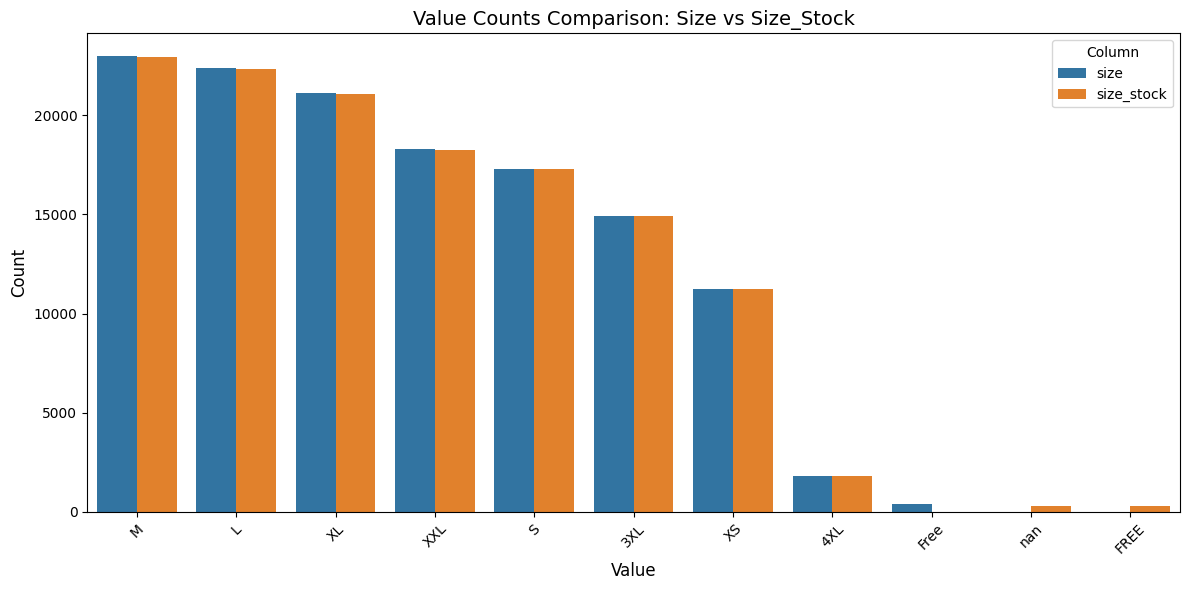

In [ ]:
# Review the distribution of 'size_stock' before normalization
Amazon_Data["size_stock"].value_counts()

# Define size normalization mapping
size_map = {
    "m": "M",
    "l": "L",
    "s": "S",
    "xl": "XL",
    "xxl": "XXL",
    "xxxl": "3XL",
    "XXXL": "3XL",
    "S TO XXL": "Free",   # unified as 'Free'
    "6XL": "4XL",
    "5XL": "4XL"
}

# Apply normalization mapping
Amazon_Data["size_stock"] = Amazon_Data["size_stock"].replace(size_map)

# Convert to categorical type for efficiency
Amazon_Data["size_stock"] = Amazon_Data["size_stock"].astype("category")

# Review final value distribution after normalization
Amazon_Data["size_stock"].value_counts()

#cheking size vs size_stock if similar or not

import matplotlib.pyplot as plt
import seaborn as sns
# Create a copy of the original DataFrame
df_copy = Amazon_Data.copy()

# Convert columns to string type to prevent type errors
df_copy["size"] = df_copy["size"].astype(str)
df_copy["size_stock"] = df_copy["size_stock"].astype(str)

# Count values for each column
size_counts = df_copy["size"].value_counts().reset_index()
size_counts.columns = ["Value", "Count"]
size_counts["Column"] = "size"

size_stock_counts = df_copy["size_stock"].value_counts().reset_index()
size_stock_counts.columns = ["Value", "Count"]
size_stock_counts["Column"] = "size_stock"

# Combine both count tables into one
combined_counts = pd.concat([size_counts, size_stock_counts])

# Create a single bar plot to compare both columns
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_counts, x="Value", y="Count", hue="Column")

# Customize the chart
plt.title("Value Counts Comparison: Size vs Size_Stock", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Column", loc="upper right")
plt.tight_layout()
plt.show()


# Drop the 'size_stock' column directly from the original DataFrame
Amazon_Data.drop(columns=["size_stock"], inplace=True)



In [ ]:
Amazon_Data["color"].value_counts()

import re
import pandas as pd

# 1) Basic text cleanup
raw = (
    Amazon_Data["color"]
    .astype("string")
    .str.strip()
)

def normalize_color(v: str):
    if v is pd.NA or v is None:
        return v
    x = re.sub(r"[^A-Za-z\s]", " ", str(v)).upper()     # remove symbols like ':', '_', etc.
    x = re.sub(r"\s+", " ", x).strip()

    # 2) Mapping dictionary for synonyms / variations
    syn = {
        "OFF WHITE": "White",
        "OFFWHITE": "White",
        "IVORY": "White",

        "CREAM": "Cream",  # if you want to merge with Off White, change to "Off White"
        "BEIGE": "Beige",

        "NAVY": "Blue",
        "NAVY BLUE": "Blue",
        "DARK BLUE": "Blue",

        "TEAL BLUE": "Blue",
        "TEAL GREEN": "Green",
        "LIGHT GREEN": "Green",

        "TURQUOISE": "Turquoise",
        "TURQUOISE BLUE": "Turquoise",
        "TURQUOISE GREEN": "Turquoise",

        "LEMON": "Yellow",
        "LEMON YELLOW": "Yellow",

        "MINT": "Green",
        "MINT GREEN": "Green",

        "OLIVE": "Green",
        "OLIVE GREEN": "Green",

        "LIGHT BROWN": "Brown",

        "GREY": "Grey",
        "GRAY": "Grey",

        "BURGUNDY": "Maroon",
        "WINE": "Maroon",

        "MULTI COLOR": "Multicolor",
        "MULTICOLOR": "Multicolor",

        "CORAL": "Coral",
        "CORAL PINK": "Coral",
        "CORAL ORANGE": "Coral",

        "POWDER BLUE": "Blue",
        "SKY BLUE": "Blue",
        "LIGHT BLUE": "Blue",

        "CHARCOAL": "Brown",
        "BROWN": "Brown",
        "CHOCOLATE": "Brown",
        "TAUPE": "Grey",
        "KHAKI": "Yellow",
        "LIGHT YELLOW": "Yellow",
        "LIME GREEN": "Green",
        "LIGHT PINK": "Pink",
        "DARK GREEN": "Green",
        "SEA GREEN": "Green",
        "CHIKU": "Beige"
    }

    # 3) Direct dictionary match
    if x in syn:
        return syn[x]

    # 4) Pattern for shades: LIGHT/DARK + base color
    m = re.match(r"^(LIGHT|DARK)\s+(.*)$", x)
    if m:
        shade, base = m.groups()
        base = base.strip()
        base_std = syn.get(base, base.title())
        return f"{shade.title()} {base_std}"

    # 5) Default: Title Case
    return x.title()

# 6) Apply normalization and create new column
Amazon_Data["color_norm"] = raw.map(normalize_color)

# Count normalized values
counts_after = Amazon_Data["color_norm"].value_counts(dropna=False)

# 7) Comparison table (before/after)
counts_before = raw.value_counts(dropna=False).rename("count_before")
compare = (
    pd.concat([counts_before, counts_after.rename("count_after")], axis=1)
    .fillna(0).astype(int)
    .assign(diff=lambda df: df["count_after"] - df["count_before"])
    .sort_values("count_after", ascending=False)
)

print("== Normalized value counts ==")
print(counts_after.head(50))
print("\n== Before/After comparison (top 50) ==")
print(compare.head(50))


== Normalized value counts ==
color_norm
Green         22568
Blue          19934
Pink          12943
White          9408
Mustard        8686
Black          7930
Teal           7372
Peach          6545
Maroon         5521
Grey           4366
Red            3515
Turquoise      3221
Orange         3044
Yellow         2951
Cream          2617
Brown          2108
Multicolor     1778
Magenta        1407
Beige          1197
Gold            941
Coral           515
Mauve           500
Rust            408
Indigo          357
Purple          312
<NA>            282
Name: count, dtype: int64

== Before/After comparison (top 50) ==
                 count_before  count_after  diff
Green                   13385        22568  9183
Blue                    14507        19934  5427
Pink                    12004        12943   939
White                    5480         9408  3928
Mustard                  8686         8686     0
Black                    7930         7930     0
Teal                     7372 

In [ ]:
# Review normalized color distribution
Amazon_Data["color_norm"].value_counts()

# Convert 'color_norm' column to string type for consistency
Amazon_Data["color_norm"] = Amazon_Data["color_norm"].astype("string")

# Drop the original 'color' column (no longer needed after normalization)
Amazon_Data = Amazon_Data.drop(columns=["color"])


In [ ]:
# Review 'fulfilment' distribution before conversion
Amazon_Data["fulfilment"].value_counts()

# Convert 'fulfilment' column to categorical type for memory efficiency
Amazon_Data["fulfilment"] = Amazon_Data["fulfilment"].astype("category")


In [ ]:
# Review 'category_stock' value distribution before dropping
Amazon_Data["category_stock"].value_counts()

# Drop the original 'category_stock' column (after normalization was completed)
Amazon_Data = Amazon_Data.drop(columns=["category_stock"])


In [ ]:
# Review the distribution of 'sku_id_stock' before dropping
Amazon_Data["sku_id_stock"].value_counts()

# Drop the 'sku_id_stock' column (no longer needed)
Amazon_Data = Amazon_Data.drop(columns=["sku_id_stock"])


In [ ]:
# Review the distribution of 'sku_size_stock' before dropping
Amazon_Data["sku_size_stock"].value_counts()

# Drop the 'sku_size_stock' column (no longer needed)
Amazon_Data = Amazon_Data.drop(columns=["sku_size_stock"])


In [ ]:
# Rename the column 'design_no.' to 'design_no' for consistency
Amazon_Data.rename(columns={"design_no.": "design_no"}, inplace=True)


In [ ]:
# Build a summary table describing each column in the DataFrame
summary = pd.DataFrame({
    "column": Amazon_Data.columns,                  # column names
    "dtype": Amazon_Data.dtypes.values,             # data types
    "null_count": Amazon_Data.isnull().sum().values, # number of missing values per column
    "unique_count": Amazon_Data.nunique().values     # number of unique values per column
})

# Display the summary table
print(summary)


                 column           dtype  null_count  unique_count
0                 index           int64           0        128975
1              order_id  string[python]        1424        120378
2                  date  datetime64[ns]           0            91
3            fulfilment        category        1424             1
4    ship-service-level        category        1424             2
..                  ...             ...         ...           ...
56        has_promotion            bool           0             2
57     seller_easy_ship            bool           0             2
58       customer_clean  string[python]      129002            35
59  category_stock_norm  string[python]         282            17
60           color_norm  string[python]         282            25

[61 rows x 4 columns]


In [ ]:
# Save the cleaned and processed DataFrame to a Pickle file
Amazon_Data.to_pickle("best_dataset_clean_1.pkl")


##Phase two of the data cleaning process

In [ ]:
# Drop unnecessary columns before performing EDA (Exploratory Data Analysis)
import pandas as pd

# Load the cleaned dataset from pickle
df = pd.read_pickle("best_dataset_clean_1.pkl")

# Remove columns that are not required for analysis
df = df.drop(columns=["index", "order_id", "sku_id_size", "sku_clean", "sku_new", "sku_code", "style_id"])


In [ ]:
# Review current category distribution
df["category"].value_counts()

import pandas as pd

# Map old category names to new standardized ones
category_map = {
    "Ethnic Dress": "kurta",
    "Blouse": "Top",
    "Saree": "kurta",
    "Bottom": "Western Dress"
}

# Apply category mapping and convert to string
df["category"] = (
    df["category"]
    .astype("string")
    .replace(category_map)
)

# Convert back to categorical type for efficiency
df["category"] = df["category"].astype("category")

# Verify the updated category distribution
print(df["category"].value_counts())


category
kurta            51230
Set              50284
Western Dress    15940
Top              11548
Name: count, dtype: int64


In [ ]:
# Display the current distribution of courier status values
df["courier_status"].value_counts()


,count
courier_status,
Shipped,109510
Unshipped,6682
Cancelled,5938


In [ ]:
# Display value counts for the 'status_first_word' column  (TARGET)
df["status_first_word"].value_counts()



,count
status_first_word,
Shipped,109719
Cancelled,18336
Pending,939
Shipping,8


In [ ]:
# Normalize 'status_first_word' values by merging similar categories
df["status_first_word"] = (
    df["status_first_word"]
    .astype("string")
    .replace({"Cancelled": "Shipped", "Shipping": "Shipped"})
)

# Convert to categorical type for optimized storage
df["status_first_word"] = df["status_first_word"].astype("category")

# Display updated status value distribution
df["status_first_word"].value_counts()

# Rename the column for clarity
df.rename(columns={'status_first_word': 'status'}, inplace=True)


In [ ]:
df.status.value_counts()


,count
status,
Shipped,128063
Pending,939


In [ ]:
import pandas as pd
import numpy as np

# Function to map month numbers to corresponding seasons
def map_month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8, 9]:
        return "Monsoon"
    elif month in [10, 11]:
        return "Post-Monsoon"
    else:
        return np.nan  # handle missing or invalid month values

# Apply the function to the 'month' column
df["season"] = df["month"].apply(map_month_to_season)

# Convert to categorical type for optimized memory usage
df["season"] = df["season"].astype("category")

# Verify distribution of season categories
print(df["season"].value_counts())


season
Summer     92727
Monsoon    37699
Name: count, dtype: int64


In [ ]:
# Ensure 'ship-city_norm' column is stored as string type
df["ship-city_norm"] = df["ship-city_norm"].astype("string")



In [ ]:
# Drop unnecessary columns 'year' and 'rate' from the DataFrame
df.drop(columns=["year", "rate"], inplace=True)


In [ ]:
import pandas as pd

# Convert numeric weekday values to weekday names
weekday_map = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}
df["weekday"] = df["weekday"].map(weekday_map).astype("category")

# Convert numeric month values to month names
month_map = {
    1: "January", 2: "February", 3: "March",
    4: "April",   5: "May",      6: "June",
    7: "July",    8: "August",   9: "September",
    10: "October",11: "November",12: "December"
}
df["month"] = df["month"].map(month_map).astype("category")


In [ ]:
# Clean extra spaces / inconsistent casing if needed
# df["courier_status"] = df["courier_status"].astype(str).str.strip()

# If pcs = 0 and courier_status = "Shipped" → set pcs = 1
mask_shipped = (df["pcs"] == 0) & (df["courier_status"].str.lower() == "shipped")
df.loc[mask_shipped, "pcs"] = 1

# If courier_status = "Unshipped" → set pcs = 0
mask_unshipped = df["courier_status"].str.lower() == "unshipped"
df.loc[mask_unshipped, "pcs"] = 0

# Convert pcs column to integer type
df["pcs"] = df["pcs"].astype(int)

# Quick verification
print(df["pcs"].value_counts())


pcs
1    110495
0     19492
2       348
3        45
5        36
4         9
8         1
Name: count, dtype: int64


In [ ]:
# Calculate unit price (amount per pcs) safely
df["unit_price"] = df["amount"] / df["pcs"]

# Verify results
print(df[["pcs", "amount", "unit_price"]].head(10))


   pcs  amount  unit_price
0    1   761.0       761.0
1    1   519.0       519.0
2    1  1165.0      1165.0
3    1   358.0       358.0
4    1   417.0       417.0
5    1   688.0       688.0
6    1   657.0       657.0
7    1   453.0       453.0
8    1   599.0       599.0
9    1   761.0       761.0


In [ ]:
# Show all rows where pcs > 1
filtered = df.loc[df["pcs"] > 1, ["pcs", "amount", "unit_price"]]

# Display all rows without truncation
pd.set_option("display.max_rows", None)

print(filtered)


        pcs  amount  unit_price
56        2     NaN         NaN
788       2   906.0       453.0
1019      2  1396.0       698.0
1464      3  1017.0       339.0
1465      3  1116.0       372.0
1691      2     NaN         NaN
1835      3  2397.0       799.0
2121      3  2016.0       672.0
2294      2  1098.0       549.0
2553      2  2066.0      1033.0
3640      2   698.0       349.0
3998      2   990.0       495.0
4052      2   834.0       417.0
4375      2   900.0       450.0
5223      2   852.0       426.0
5357      2   560.0       280.0
5978      2  1236.0       618.0
6372      2  1916.0       958.0
6496      2   990.0       495.0
6740      8  5584.0       698.0
7310      2  1292.0       646.0
7361      2  1292.0       646.0
7518      5     NaN         NaN
7519      5     NaN         NaN
7598      2     NaN         NaN
7599      2     NaN         NaN
7600      2     NaN         NaN
7601      2     NaN         NaN
7602      2     NaN         NaN
7603      2     NaN         NaN
7604    

In [ ]:
# Define ordered categories for 'pcs' column based on existing values
df['pcs'] = pd.Categorical(df['pcs'], categories=[0, 1, 2, 3, 4, 5], ordered=True)

# Check the data type to confirm conversion
df['pcs'].dtype

# Display defined category order
df['pcs'].cat.categories


Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [ ]:
# Remove the 'courier_status' column from the DataFrame
# Note: removed because it is almost similar to the target 'status' column
df = df.drop(columns=["courier_status"])


##Remove all columns that have more than 60% missing values and cannot be filled.

In [ ]:
df_cleaned = df.copy()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 53 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  130426 non-null  datetime64[ns]
 1   fulfilment            129002 non-null  category      
 2   ship-service-level    129002 non-null  category      
 3   category              129002 non-null  category      
 4   size                  130426 non-null  category      
 5   asin                  129002 non-null  string        
 6   pcs                   130425 non-null  category      
 7   currency              121204 non-null  string        
 8   amount                121204 non-null  float64       
 9   ship-state            128969 non-null  string        
 10  ship-postal-code      128969 non-null  Int64         
 11  ship-country          130393 non-null  category      
 12  b2b                   129002 non-null  boolean       
 13 

In [ ]:
# Drop columns with more than 60% missing values
col_threshold = 0.6
df_cleaned = df_cleaned.loc[:, df_cleaned.isna().mean() < col_threshold]

# Drop rows with more than 60% missing values
row_threshold = 0.6
df_cleaned = df_cleaned.loc[df.isna().mean(axis=1) < row_threshold, :]

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Print summary
print("Data cleaned successfully.")
print(f"Remaining rows: {df_cleaned.shape[0]}, columns: {df_cleaned.shape[1]}")

# Display info
df_cleaned.info()


Data cleaned successfully.
Remaining rows: 129002, columns: 29
<class 'pandas.core.frame.DataFrame'>
Index: 129002 entries, 0 to 130425
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  129002 non-null  datetime64[ns]
 1   fulfilment            129002 non-null  category      
 2   ship-service-level    129002 non-null  category      
 3   category              129002 non-null  category      
 4   size                  129002 non-null  category      
 5   asin                  129002 non-null  string        
 6   pcs                   129001 non-null  category      
 7   currency              121204 non-null  string        
 8   amount                121204 non-null  float64       
 9   ship-state            128969 non-null  string        
 10  ship-postal-code      128969 non-null  Int64         
 11  ship-country          128969 non-null  category      
 12  

In [ ]:
# Build a summary table showing column metadata
summary = pd.DataFrame({
    "column": df_cleaned.columns,                   # column names
    "dtype": df_cleaned.dtypes.values,              # data types
    "null_count": df_cleaned.isnull().sum().values, # number of missing values
    "unique_count": df_cleaned.nunique().values     # number of unique values
})

# Display the summary table
print(summary)


                  column           dtype  null_count  unique_count
0                   date  datetime64[ns]           0            91
1             fulfilment        category           0             1
2     ship-service-level        category           0             2
3               category        category           0             4
4                   size        category           0             9
5                   asin  string[python]           0          7190
6                    pcs        category           1             6
7               currency  string[python]        7798             1
8                 amount         float64        7798          1410
9             ship-state  string[python]          33            47
10      ship-postal-code           Int64          33          9459
11          ship-country        category          33             1
12                   b2b         boolean           0             2
13                   day           int64           0          

In [ ]:
# Save the updated and cleaned DataFrame to a new Pickle file
df_cleaned.to_pickle("best_dataset_clean_2.1.pkl")
